# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\hemant\Anaconda\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'G:\database_assignment\Logistic_regression\database5.sqlite') 
# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
if not os.path.isfile('final.sqlite'):
    
    from tqdm import tqdm
    final_string=[]
    # tqdm is for printing the status bar
    for sentance in tqdm(final['Text'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        final_string.append(sentance.strip())
        
         #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final05.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
   

In [23]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final1 = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [24]:
final1.head(3)
final1['CleanedText'].head(5)

0    witti littl book make son laugh loud recit car...
1    grew read sendak book watch realli rosi movi i...
2    fun way children learn month year learn poem t...
3    great littl book read nice rhythm well good re...
4    book poetri month year goe month cute littl po...
Name: CleanedText, dtype: object

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
sorted_sample = final1.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')    
sample_60000 = sorted_sample.iloc[0:100000]
final.shape
y = sample_60000['Score']

In [26]:
sample_60000.shape

(100000, 12)

In [27]:
sample_60000["length"] = sample_60000['Text'].apply(len)

In [28]:
sample_60000.shape

(100000, 13)

In [29]:
sample_60000.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,length
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,375
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,407
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,166


In [30]:
sample_60000['Score'].value_counts()

1    87729
0    12271
Name: Score, dtype: int64

In [31]:
from sklearn.model_selection import train_test_split

x_tr, x_ts, y_tr, y_ts = train_test_split(sample_60000, y, test_size=0.20) # this is random splitting

In [32]:
x_train, x_cv, y_train, y_cv = train_test_split(x_tr, y_tr, test_size=0.25) # this is random splitting

In [33]:
x_train.shape

(60000, 13)

In [34]:
y_train.shape

(60000,)

# [4] Featurization

## [4.1] BAG OF WORDS

## [4.2] Bi-Grams and n-Grams.

In [97]:
#bi-gram, tri-gram and n-gram
from sklearn import preprocessing


#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1, 2),min_df=10) #in scikit-learn
x_tr_final_counts_bigram = count_vect.fit_transform(x_train['CleanedText'].values)
x_cv_final_counts_bigram = count_vect.transform(x_cv['CleanedText'].values)
x_ts_final_counts_bigram = count_vect.transform(x_ts['CleanedText'].values)


print("the type of count vectorizer ",type(x_tr_final_counts_bigram))
print("the shape of out text BOW vectorizer ",x_tr_final_counts_bigram.get_shape())
print("the number of unique words ", x_tr_final_counts_bigram.get_shape()[1])

print("the type of count vectorizer ",type(x_cv_final_counts_bigram))
print("the shape of out text BOW vectorizer ",x_cv_final_counts_bigram.get_shape())
print("the number of unique words ", x_cv_final_counts_bigram.get_shape()[1])

print("the type of count vectorizer ",type(x_ts_final_counts_bigram))
print("the shape of out text BOW vectorizer ",x_ts_final_counts_bigram.get_shape())
print("the number of unique words ", x_ts_final_counts_bigram.get_shape()[1])


x_tr_final_counts_bigram = preprocessing.normalize(x_tr_final_counts_bigram)
x_cv_final_counts_bigram = preprocessing.normalize(x_cv_final_counts_bigram)
x_ts_final_counts_bigram = preprocessing.normalize(x_ts_final_counts_bigram)





the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 34443)
the number of unique words  34443
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 34443)
the number of unique words  34443
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 34443)
the number of unique words  34443


## [4.3] TF-IDF

In [98]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1, 2),min_df=10)
x_tr_final_counts_tfidf = tf_idf_vect.fit_transform(x_train['CleanedText'].values)
x_cv_final_counts_tfidf = tf_idf_vect.transform(x_cv['CleanedText'].values)
x_ts_final_counts_tfidf = tf_idf_vect.transform(x_ts['CleanedText'].values)


print("the type of count vectorizer ",type(x_tr_final_counts_tfidf))
print("the shape of out text TFIDF vectorizer ",x_tr_final_counts_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_tr_final_counts_tfidf.get_shape()[1])

print("the type of count vectorizer ",type(x_cv_final_counts_tfidf))
print("the shape of out text TFIDF vectorizer ",x_cv_final_counts_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_cv_final_counts_tfidf.get_shape()[1])

print("the type of count vectorizer ",type(x_ts_final_counts_tfidf))
print("the shape of out text TFIDF vectorizer ",x_ts_final_counts_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_ts_final_counts_tfidf.get_shape()[1])


x_tr_final_counts_tfidf = preprocessing.normalize(x_tr_final_counts_tfidf)
x_cv_final_counts_tfidf = preprocessing.normalize(x_cv_final_counts_tfidf)
x_ts_final_counts_tfidf = preprocessing.normalize(x_ts_final_counts_tfidf)



the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 34443)
the number of unique words including both unigrams and bigrams  34443
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 34443)
the number of unique words including both unigrams and bigrams  34443
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 34443)
the number of unique words including both unigrams and bigrams  34443


## [4.4] Word2Vec

In [99]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in x_train['CleanedText'].values:
    list_of_sentance_train.append(sentance.split())

In [100]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_cv=[]
for sentance in x_cv['CleanedText'].values:
    list_of_sentance_cv.append(sentance.split())

In [101]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_ts=[]
for sentance in x_ts['CleanedText'].values:
    list_of_sentance_ts.append(sentance.split())

In [102]:
print(len(list_of_sentance_train))
print(len(list_of_sentance_cv))
print(len(list_of_sentance_ts))

60000
20000
20000


In [103]:
def convertByteStringtoString(sentlist):
    for x in sentlist:
        for i in range(len(x)):
            x[i] = x[i]
            
    return sentlist

In [104]:
list_of_sentance_train = convertByteStringtoString(list_of_sentance_train)
list_of_sentance_cv = convertByteStringtoString(list_of_sentance_cv)
list_of_sentance_ts = convertByteStringtoString(list_of_sentance_ts)

In [105]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [106]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10040
sample words  ['tea', 'parti', 'theme', 'babi', 'shower', 'son', 'wife', 'purchas', 'numi', 'bamboo', 'gift', 'set', 'clear', 'pot', 'flower', 'describ', 'put', 'teapot', 'convers', 'great', 'open', 'make', 'part', 'event', 'know', 'guest', 'talk', 'next', 'day', 'chickpea', 'bean', 'excel', 'sourc', 'mani', 'miner', 'protein', 'two', 'pack', 'order', 'get', 'free', 'ship', 'care', 'select', 'fresh', 'smell', 'use', 'most', 'soup', 'automat']


[4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

[4.4.1.1] Avg W2v

In [107]:
# average Word2Vec
# compute average word2vec for each review.

train_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_avgw2v.append(sent_vec)
print(len(train_avgw2v))
print(len(train_avgw2v[0]))

100%|███████████████████████████████████| 60000/60000 [01:49<00:00, 546.04it/s]


60000
50


In [108]:

cv_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_avgw2v.append(sent_vec)
print(len(cv_avgw2v))
print(len(cv_avgw2v[0]))


100%|███████████████████████████████████| 20000/20000 [00:36<00:00, 541.23it/s]


20000
50


In [109]:
test_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_ts): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_avgw2v.append(sent_vec)
print(len(test_avgw2v))
print(len(test_avgw2v[0]))

100%|███████████████████████████████████| 20000/20000 [00:36<00:00, 540.56it/s]


20000
50


In [110]:
train_avgw2v = preprocessing.normalize(train_avgw2v)
cv_avgw2v = preprocessing.normalize(cv_avgw2v)
test_avgw2v = preprocessing.normalize(test_avgw2v)

In [111]:
train_avgw2v = np.array(train_avgw2v)
cv_avgw2v = np.array(cv_avgw2v)
test_avgw2v = np.array(test_avgw2v)

In [112]:
np.isnan(train_avgw2v).any()


False

In [113]:
np.isnan(cv_avgw2v).any()


False

In [114]:
np.isnan(test_avgw2v).any()

False

[4.4.1.2] TFIDF weighted W2v

In [115]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
x_tr_final_counts_TFIDF_w2v = model.fit_transform(x_train['CleanedText'].values)
x_cv_final_counts_TFIDF_w2v = model.transform(x_cv['CleanedText'].values)
x_ts_final_counts_TFIDF_w2v = model.transform(x_ts['CleanedText'].values)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [116]:
# TF-IDF weighted Word2Vec Train Data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 60000/60000 [20:02<00:00, 49.88it/s]


In [117]:

# TF-IDF weighted Word2Vec cv Data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
    

100%|████████████████████████████████████| 20000/20000 [06:53<00:00, 48.36it/s]


In [118]:
# TF-IDF weighted Word2Vec test Data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_ts = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_ts): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_ts.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 20000/20000 [06:39<00:00, 50.06it/s]


In [119]:
tfidf_sent_vectors = preprocessing.normalize(tfidf_sent_vectors)
tfidf_sent_vectors_cv = preprocessing.normalize(tfidf_sent_vectors_cv)
tfidf_sent_vectors_ts = preprocessing.normalize(tfidf_sent_vectors_ts)


In [120]:
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)
tfidf_sent_vectors_ts = np.array(tfidf_sent_vectors_ts)

In [121]:
np.isnan(tfidf_sent_vectors).any()


False

In [122]:
np.isnan(tfidf_sent_vectors_cv).any()


False

In [123]:
np.isnan(tfidf_sent_vectors_ts).any()


False

#RBF

In [35]:
sorted_sample1 = final1.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')    
sample_600001 = sorted_sample1.iloc[0:20000]

y1 = sample_600001['Score']


In [36]:
sample_600001.shape

(20000, 12)

In [37]:
sample_600001["length"] = sample_600001['Text'].apply(len)

In [38]:
sample_600001.shape

(20000, 13)

In [39]:
sample_600001.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,length
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,375
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,407
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,166


In [40]:
sample_600001['Score'].value_counts()

1    17826
0     2174
Name: Score, dtype: int64

In [41]:
from sklearn.model_selection import train_test_split

x_tr_rbf, x_ts_rbf, y_tr_rbf, y_ts_rbf = train_test_split(sample_600001, y1, test_size=0.20) # this is random splitting

In [42]:
x_train_rbf, x_cv_rbf, y_train_rbf, y_cv_rbf = train_test_split(x_tr_rbf, y_tr_rbf, test_size=0.25) # this is random splitting

In [43]:
x_train_rbf.shape

(12000, 13)

In [44]:
y_train_rbf.shape

(12000,)

In [45]:
x_ts_rbf.shape

(4000, 13)

In [46]:
y_ts_rbf.shape

(4000,)

# Bi-Grams and n-Grams for rbf

In [47]:
#bi-gram, tri-gram and n-gram
from sklearn import preprocessing

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1, 2),min_df=10,max_features = 500) #in scikit-learn
x_tr_final_counts_bigram_rbf = count_vect.fit_transform(x_train_rbf['CleanedText'].values)
x_cv_final_counts_bigram_rbf = count_vect.transform(x_cv_rbf['CleanedText'].values)
x_ts_final_counts_bigram_rbf = count_vect.transform(x_ts_rbf['CleanedText'].values)


print("the type of count vectorizer ",type(x_tr_final_counts_bigram_rbf))
print("the shape of out text BOW vectorizer ",x_tr_final_counts_bigram_rbf.get_shape())
print("the number of unique words ", x_tr_final_counts_bigram_rbf.get_shape()[1])

print("the type of count vectorizer ",type(x_cv_final_counts_bigram_rbf))
print("the shape of out text BOW vectorizer ",x_cv_final_counts_bigram_rbf.get_shape())
print("the number of unique words ", x_cv_final_counts_bigram_rbf.get_shape()[1])

print("the type of count vectorizer ",type(x_ts_final_counts_bigram_rbf))
print("the shape of out text BOW vectorizer ",x_ts_final_counts_bigram_rbf.get_shape())
print("the number of unique words ", x_ts_final_counts_bigram_rbf.get_shape()[1])


x_tr_final_counts_bigram_rbf = preprocessing.normalize(x_tr_final_counts_bigram_rbf)
x_cv_final_counts_bigram_rbf = preprocessing.normalize(x_cv_final_counts_bigram_rbf)
x_ts_final_counts_bigram_rbf = preprocessing.normalize(x_ts_final_counts_bigram_rbf)




the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (12000, 500)
the number of unique words  500
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4000, 500)
the number of unique words  500
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4000, 500)
the number of unique words  500


# tf_idf for rbf

In [48]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1, 2),min_df=10,max_features = 500)
x_tr_final_counts_tfidf_rbf = tf_idf_vect.fit_transform(x_train_rbf['CleanedText'].values)
x_cv_final_counts_tfidf_rbf = tf_idf_vect.transform(x_cv_rbf['CleanedText'].values)
x_ts_final_counts_tfidf_rbf = tf_idf_vect.transform(x_ts_rbf['CleanedText'].values)

x_tr_final_counts_tfidf_rbf = preprocessing.normalize(x_tr_final_counts_tfidf_rbf)
x_cv_final_counts_tfidf_rbf = preprocessing.normalize(x_cv_final_counts_tfidf_rbf)
x_ts_final_counts_tfidf_rbf = preprocessing.normalize(x_ts_final_counts_tfidf_rbf)


print("the type of count vectorizer ",type(x_tr_final_counts_tfidf_rbf))
print("the shape of out text TFIDF vectorizer ",x_tr_final_counts_tfidf_rbf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_tr_final_counts_tfidf_rbf.get_shape()[1])

print("the type of count vectorizer ",type(x_cv_final_counts_tfidf_rbf))
print("the shape of out text TFIDF vectorizer ",x_cv_final_counts_tfidf_rbf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_cv_final_counts_tfidf_rbf.get_shape()[1])

print("the type of count vectorizer ",type(x_ts_final_counts_tfidf_rbf))
print("the shape of out text TFIDF vectorizer ",x_ts_final_counts_tfidf_rbf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_ts_final_counts_tfidf_rbf.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (12000, 500)
the number of unique words including both unigrams and bigrams  500
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4000, 500)
the number of unique words including both unigrams and bigrams  500
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4000, 500)
the number of unique words including both unigrams and bigrams  500


#Word2Vec Train Data

In [49]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_rbf=[]
for sentance in x_train_rbf['CleanedText'].values:
    list_of_sentance_rbf.append(sentance.split())

In [50]:

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_cv_rbf=[]
for sentance in x_cv_rbf['CleanedText'].values:
    list_of_sentance_cv_rbf.append(sentance.split())

    

In [51]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_ts_rbf=[]
for sentance in x_ts_rbf['CleanedText'].values:
    list_of_sentance_ts_rbf.append(sentance.split())

In [52]:
print(len(list_of_sentance_rbf))
print(len(list_of_sentance_cv_rbf))
print(len(list_of_sentance_ts_rbf))

12000
4000
4000


In [53]:
def convertByteStringtoString(sentlist):
    for x in sentlist:
        for i in range(len(x)):
            x[i] = x[i]
            
    return sentlist

In [54]:
list_of_sentance_rbf = convertByteStringtoString(list_of_sentance_rbf)
list_of_sentance_cv_rbf = convertByteStringtoString(list_of_sentance_cv_rbf)
list_of_sentance_ts_rbf = convertByteStringtoString(list_of_sentance_ts_rbf)

In [55]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_rbf=Word2Vec(list_of_sentance_rbf,min_count=5,size=500, workers=4)

In [56]:
w2v_words_rbf = list(w2v_model_rbf.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_rbf))
print("sample words ", w2v_words_rbf[0:500])

number of words that occured minimum 5 times  4972
sample words  ['one', 'review', 'said', 'care', 'dont', 'eat', 'entir', 'packag', 'well', 'didnt', 'work', 'incred', 'order', 'case', 'last', 'week', 'offic', 'find', 'pretzel', 'better', 'real', 'delici', 'organ', 'full', 'flavor', 'hit', 'hous', 'plump', 'rice', 'fat', 'carrot', 'tasti', 'chicken', 'great', 'soup', 'titl', 'pretti', 'much', 'say', 'reserv', 'star', 'consid', 'best', 'want', 'cereal', 'differ', 'ive', 'year', 'definit', 'like', 'usual', 'crispi', 'substanti', 'air', 'nice', 'though', 'strong', 'cocoa', 'doesnt', 'get', 'soggi', 'first', 'two', 'minut', 'milk', 'drink', 'product', 'pour', 'anoth', 'talk', 'empti', 'calori', 'ill', 'generous', 'assum', 'particular', 'familiar', 'read', 'compar', 'nutrit', 'label', 'high', 'qualiti', 'also', 'would', 'crisp', 'reveal', 'almost', 'ident', 'valu', 'perhap', 'never', 'claim', 'fulli', 'balanc', 'meal', 'neither', 'made', 'ingredi', 'none', 'artifici', 'vitamin', 'miner', 'a

In [57]:
# Converting text into vectors using Avg W2V, TFIDF-W2V

In [58]:
 # Avg W2v rbf

In [59]:
# average Word2Vec
# compute average word2vec for each review.

train_avgw2v_rbf = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_rbf): # for each review/sentence
    sent_vec = np.zeros(500) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_rbf:
            vec = w2v_model_rbf.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_avgw2v_rbf.append(sent_vec)
print(len(train_avgw2v_rbf))
print(len(train_avgw2v_rbf[0]))

100%|███████████████████████████████████| 12000/12000 [00:17<00:00, 680.31it/s]


12000
500


In [60]:

cv_avgw2v_rbf = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv_rbf): # for each review/sentence
    sent_vec = np.zeros(500) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_rbf:
            vec = w2v_model_rbf.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_avgw2v_rbf.append(sent_vec)
print(len(cv_avgw2v_rbf))
print(len(cv_avgw2v_rbf[0]))


100%|█████████████████████████████████████| 4000/4000 [00:05<00:00, 681.46it/s]


4000
500


In [61]:
test_avgw2v_rbf = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_ts_rbf): # for each review/sentence
    sent_vec = np.zeros(500) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_rbf:
            vec = w2v_model_rbf.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_avgw2v_rbf.append(sent_vec)
print(len(test_avgw2v_rbf))
print(len(test_avgw2v_rbf[0]))

100%|█████████████████████████████████████| 4000/4000 [00:05<00:00, 678.59it/s]


4000
500


In [62]:

train_avgw2v_rbf = preprocessing.normalize(train_avgw2v_rbf)
cv_avgw2v_rbf = preprocessing.normalize(cv_avgw2v_rbf)
test_avgw2v_rbf = preprocessing.normalize(test_avgw2v_rbf)


In [63]:
train_avgw2v_rbf = np.array(train_avgw2v_rbf)
cv_avgw2v_rbf = np.array(cv_avgw2v_rbf)
test_avgw2v_rbf = np.array(test_avgw2v_rbf)

In [64]:
np.isnan(train_avgw2v_rbf).any()


False

In [65]:
np.isnan(cv_avgw2v_rbf).any()

False

In [66]:
np.isnan(test_avgw2v_rbf).any()

False

In [67]:
# TFIDF weighted W2v for rbf

In [68]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df=10,max_features = 500)
x_tr_final_counts_TFIDF_w2v_rbf = model.fit_transform(x_train_rbf['CleanedText'].values)
x_cv_final_counts_TFIDF_w2v_rbf = model.transform(x_cv_rbf['CleanedText'].values)
x_ts_final_counts_TFIDF_w2v_rbf = model.transform(x_ts_rbf['CleanedText'].values)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [69]:
# TF-IDF weighted Word2Vec Train Data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_rbf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_rbf): # for each review/sentence 
    sent_vec = np.zeros(500) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_rbf and word in tfidf_feat:
            vec = w2v_model_rbf.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_rbf.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 12000/12000 [00:23<00:00, 518.19it/s]


In [70]:
# TF-IDF weighted Word2Vec cv Data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv_rbf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv_rbf): # for each review/sentence 
    sent_vec = np.zeros(500) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_rbf and word in tfidf_feat:
            vec = w2v_model_rbf.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv_rbf.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 4000/4000 [00:08<00:00, 499.41it/s]


In [71]:
# TF-IDF weighted Word2Vec test Data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_ts_rbf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_ts_rbf): # for each review/sentence 
    sent_vec = np.zeros(500) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_rbf and word in tfidf_feat:
            vec = w2v_model_rbf.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_ts_rbf.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 4000/4000 [00:07<00:00, 522.85it/s]


In [72]:
tfidf_sent_vectors_rbf = preprocessing.normalize(tfidf_sent_vectors_rbf)
tfidf_sent_vectors_cv_rbf = preprocessing.normalize(tfidf_sent_vectors_cv_rbf)
tfidf_sent_vectors_ts_rbf = preprocessing.normalize(tfidf_sent_vectors_ts_rbf)


In [73]:
tfidf_sent_vectors_rbf = np.array(tfidf_sent_vectors_rbf)
tfidf_sent_vectors_cv_rbf = np.array(tfidf_sent_vectors_cv_rbf)
tfidf_sent_vectors_ts_rbf = np.array(tfidf_sent_vectors_ts_rbf)

In [74]:
np.isnan(tfidf_sent_vectors_rbf).any()


False

In [75]:
np.isnan(tfidf_sent_vectors_ts_rbf).any()


False

In [76]:
np.isnan(tfidf_sent_vectors_cv_rbf).any()


False

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

Best alpha is:- 0.0001


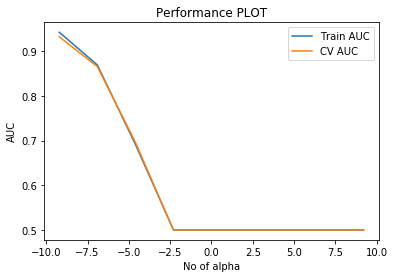

In [142]:
# Please write all the code with proper documentation
# Linear kernel svm for L1 penalty
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

alpha_values = np.arange(10)
 
acc = np.empty(len(alpha_values))
error = np.empty(len(alpha_values))
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])

cv_auc = []
train_auc = []
i = 0
for alpha in C:
    clf = SGDClassifier(loss='hinge',penalty='l1',alpha = alpha,class_weight='balanced')
    clf.fit(x_tr_final_counts_bigram, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_tr_final_counts_bigram, y_train)
    y_cv_pred = sig_clf.predict_proba(x_cv_final_counts_bigram)[:,1]
    y_train_pred =  sig_clf.predict_proba(x_tr_final_counts_bigram)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best alpha is:-",best_alpha)     
    
    
C = np.log(C)    
    

plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("No of alpha")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [143]:
# SGDClassifier with best best "alpha" for l1 penalty of bow
model = SGDClassifier(loss='hinge',penalty='l1',alpha = best_alpha,class_weight='balanced')
model.fit(x_tr_final_counts_bigram,y_train)
sig_clf = CalibratedClassifierCV(model, method="sigmoid")
sig_clf.fit(x_tr_final_counts_bigram,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(x_ts_final_counts_bigram)    
    # evaluate CV AUC
auc_score_bowT_l1 = roc_auc_score(y_true=np.array(y_ts), y_score=sig_clf.predict_proba(x_ts_final_counts_bigram)[:,1])*100
auc_score_bowT_lambda_l1 = best_alpha
print('\nThe AUCScore of the SGDClassifier of best alpha = %f is %f%%' % (best_alpha, auc_score_bowT_l1))    


The AUCScore of the SGDClassifier of best alpha = 0.000100 is 93.243740%


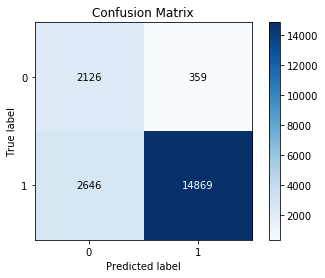

In [144]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)


False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 359/2485 = .14



In [186]:
# FPR for bowt_l1
bowt_FPR_l1 = .14

In [145]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.45      0.86      0.59      2485
          1       0.98      0.85      0.91     17515

avg / total       0.91      0.85      0.87     20000



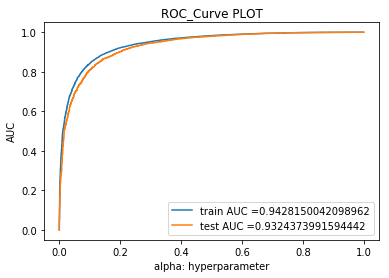

In [146]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(x_tr_final_counts_bigram)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, sig_clf.predict_proba(x_ts_final_counts_bigram)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()




Best alpha is:- 0.0001


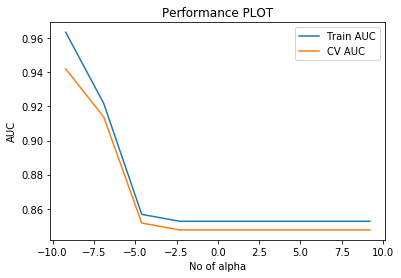

In [147]:
# Please write all the code with proper documentation
# Linear kernel svm for L1 penalty
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

alpha_values = np.arange(10)
 
acc = np.empty(len(alpha_values))
error = np.empty(len(alpha_values))
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])

cv_auc = []
train_auc = []
i = 0
for alpha in C:
    clf = SGDClassifier(loss='hinge',penalty='l2',alpha = alpha,class_weight='balanced')
    clf.fit(x_tr_final_counts_bigram, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_tr_final_counts_bigram, y_train)
    y_cv_pred = sig_clf.predict_proba(x_cv_final_counts_bigram)[:,1]
    y_train_pred =  sig_clf.predict_proba(x_tr_final_counts_bigram)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best alpha is:-",best_alpha)     
    
    
C = np.log(C)    
    

plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("No of alpha")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [148]:
# SGDClassifier with best best "alpha" for l2 penalty of bow
model = SGDClassifier(loss='hinge',penalty='l2',alpha = best_alpha,class_weight='balanced')
model.fit(x_tr_final_counts_bigram,y_train)
sig_clf = CalibratedClassifierCV(model, method="sigmoid")
sig_clf.fit(x_tr_final_counts_bigram,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(x_ts_final_counts_bigram)    
    # evaluate CV AUC
auc_score_bowT_l2 = roc_auc_score(y_true=np.array(y_ts), y_score=sig_clf.predict_proba(x_ts_final_counts_bigram)[:,1])*100
auc_score_bowT_lambda_l2 = best_alpha
print('\nThe AUCScore of the SGDClassifier of best alpha = %f is %f%%' % (best_alpha, auc_score_bowT_l2))    


The AUCScore of the SGDClassifier of best alpha = 0.000100 is 94.256361%


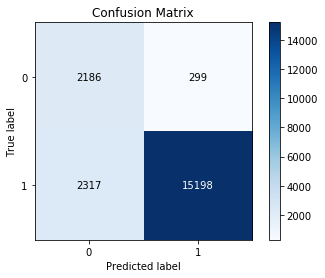

In [149]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)


False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 299/2485 = .12


In [187]:
# FPR for bowt_l2
bowt_FPR_l2 = .12

In [150]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.49      0.88      0.63      2485
          1       0.98      0.87      0.92     17515

avg / total       0.92      0.87      0.88     20000



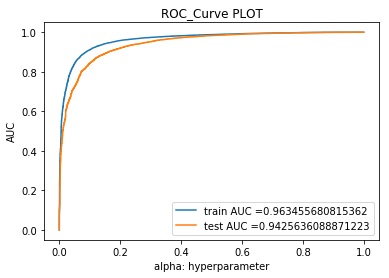

In [151]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(x_tr_final_counts_bigram)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, sig_clf.predict_proba(x_ts_final_counts_bigram)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()




Top 10 important features of positive class and Negative class

In [134]:
# Please write all the code with proper documentation
# To get all the features name 
features = count_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100:110])

some sample features(unique words in the corpus) ['action', 'activ', 'actor', 'actual', 'actual add', 'actual ate', 'actual better', 'actual bit', 'actual bought', 'actual burn']


In [135]:
#code references :- https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
n = 10 
coefs_with_fns = sorted(zip(model.coef_[0],features))
top = zip(coefs_with_fns[:n],coefs_with_fns[:-(n+1):-1])

In [136]:
print("\t\tNegative\t\t\tPositive")
print("_"*80)
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

		Negative			Positive
________________________________________________________________________________
	-4.5441	disappoint     		4.4173	delici         
	-3.9053	worst          		4.3986	best           
	-3.1496	terribl        		4.0786	excel          
	-3.0563	stale          		3.9821	perfect        
	-2.9510	unfortun       		3.8513	great          
	-2.7984	bland          		3.4021	high recommend 
	-2.6128	aw             		3.1976	favorit        
	-2.5991	return         		3.0677	amaz           
	-2.5345	horribl        		2.9748	wonder         
	-2.4838	thought        		2.9624	nice           


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

Best alpha is:- 0.0001


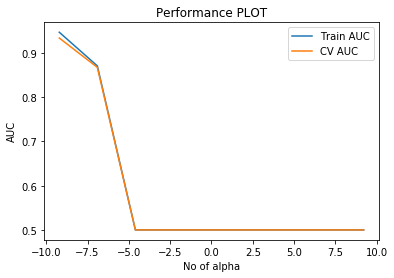

In [152]:
# Please write all the code with proper documentation
# Linear kernel svm for L1 penalty
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

alpha_values = np.arange(10)
 
acc = np.empty(len(alpha_values))
error = np.empty(len(alpha_values))
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])

cv_auc = []
train_auc = []
i = 0
for alpha in C:
    clf = SGDClassifier(loss='hinge',penalty='l1',alpha = alpha,class_weight='balanced')
    clf.fit(x_tr_final_counts_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_tr_final_counts_tfidf, y_train)
    y_cv_pred = sig_clf.predict_proba(x_cv_final_counts_tfidf)[:,1]
    y_train_pred =  sig_clf.predict_proba(x_tr_final_counts_tfidf)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best alpha is:-",best_alpha)     
    
    
C = np.log(C)    
    

plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("No of alpha")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [153]:
# SGDClassifier with best best "alpha" for l1 penalty of TFIDF
model = SGDClassifier(loss='hinge',penalty='l1',alpha = best_alpha,class_weight='balanced')
model.fit(x_tr_final_counts_tfidf,y_train)
sig_clf = CalibratedClassifierCV(model, method="sigmoid")
sig_clf.fit(x_tr_final_counts_tfidf,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(x_ts_final_counts_tfidf)    
    # evaluate CV AUC
auc_score_tfidf_l1 = roc_auc_score(y_true=np.array(y_ts), y_score=sig_clf.predict_proba(x_ts_final_counts_tfidf)[:,1])*100
auc_score_tfidf_lambda_l1 = best_alpha
print('\nThe AUCSscore of the SGDClassifier of best alpha = %f is %f%%' % (best_alpha, auc_score_tfidf_l1))    


The AUCSscore of the SGDClassifier of best alpha = 0.000100 is 93.425926%


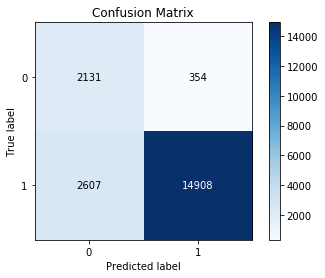

In [154]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)


False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 354/2485 = .14


In [188]:
# FPR for tfidf_l1
tfidf_FPR_l1 = .14

In [155]:
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.45      0.86      0.59      2485
          1       0.98      0.85      0.91     17515

avg / total       0.91      0.85      0.87     20000



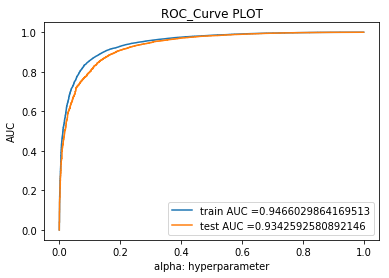

In [156]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(x_tr_final_counts_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, sig_clf.predict_proba(x_ts_final_counts_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()




Best alpha is:- 0.0001


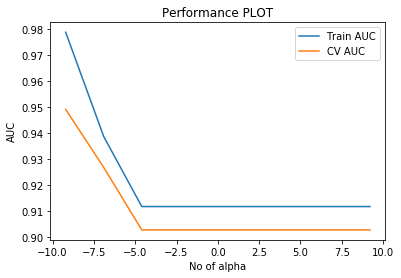

In [157]:
# Please write all the code with proper documentation
# Linear kernel svm for L1 penalty
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

alpha_values = np.arange(10)
 
acc = np.empty(len(alpha_values))
error = np.empty(len(alpha_values))
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])

cv_auc = []
train_auc = []
i = 0
for alpha in C:
    clf = SGDClassifier(loss='hinge',penalty='l2',alpha = alpha,class_weight='balanced')
    clf.fit(x_tr_final_counts_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_tr_final_counts_tfidf, y_train)
    y_cv_pred = sig_clf.predict_proba(x_cv_final_counts_tfidf)[:,1]
    y_train_pred =  sig_clf.predict_proba(x_tr_final_counts_tfidf)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best alpha is:-",best_alpha)     
    
    
C = np.log(C)    
    

plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("No of alpha")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [158]:
# SGDClassifier with best best "alpha" for l2 penalty of TFIDF
model = SGDClassifier(loss='hinge',penalty='l2',alpha = best_alpha,class_weight='balanced')
model.fit(x_tr_final_counts_tfidf,y_train)
sig_clf = CalibratedClassifierCV(model, method="sigmoid")
sig_clf.fit(x_tr_final_counts_tfidf,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(x_ts_final_counts_tfidf)    
    # evaluate CV AUC
auc_score_tfidf_l2 = roc_auc_score(y_true=np.array(y_ts), y_score=sig_clf.predict_proba(x_ts_final_counts_tfidf)[:,1])*100
auc_score_tfidf_lambda_l2 = best_alpha
print('\nThe AUCScore of the SGDClassifier of best alpha = %f is %f%%' % (best_alpha, auc_score_tfidf_l2))    


The AUCScore of the SGDClassifier of best alpha = 0.000100 is 94.992512%


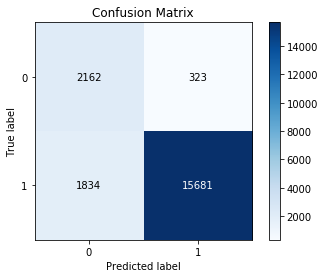

In [159]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)


False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 323/2485 = .25

In [189]:
# FPR for tfidf_l2
tfidf_FPR_l2 = .12

In [160]:
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.54      0.87      0.67      2485
          1       0.98      0.90      0.94     17515

avg / total       0.93      0.89      0.90     20000



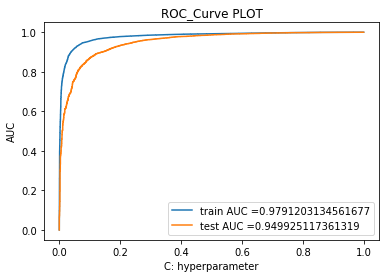

In [161]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(x_tr_final_counts_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, sig_clf.predict_proba(x_ts_final_counts_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()




Top 10 important features of positive class and Negative class

In [162]:
# Please write all the code with proper documentation
# To get all the features name 
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100:110])

some sample features(unique words in the corpus) ['action', 'activ', 'actor', 'actual', 'actual add', 'actual ate', 'actual better', 'actual bit', 'actual bought', 'actual burn']


In [163]:
#code references :- https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
n = 10 
coefs_with_fns = sorted(zip(model.coef_[0],features))
top = zip(coefs_with_fns[:n],coefs_with_fns[:-(n+1):-1])

In [164]:
print("\t\tNegative\t\t\tPositive")
print("_"*80)
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

		Negative			Positive
________________________________________________________________________________
	-5.0721	disappoint     		6.3499	great          
	-3.8446	worst          		5.5806	best           
	-3.0185	terribl        		4.8412	delici         
	-2.8107	unfortun       		4.7984	love           
	-2.7478	bland          		4.2121	perfect        
	-2.7077	stale          		4.1675	excel          
	-2.6410	horribl        		3.4475	favorit        
	-2.5758	return         		3.4409	good           
	-2.5209	thought        		3.3827	nice           
	-2.5111	bad            		3.2437	high recommend 


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

Best alpha is:- 0.0001


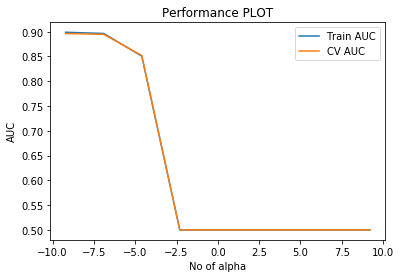

In [165]:
# Please write all the code with proper documentation
# Linear kernel svm for L1 penalty
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

alpha_values = np.arange(10)
 
acc = np.empty(len(alpha_values))
error = np.empty(len(alpha_values))
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])

cv_auc = []
train_auc = []
i = 0
for alpha in C:
    clf = SGDClassifier(loss='hinge',penalty='l1',alpha = alpha,class_weight='balanced')
    clf.fit(train_avgw2v, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_avgw2v, y_train)
    y_cv_pred = sig_clf.predict_proba(cv_avgw2v)[:,1]
    y_train_pred =  sig_clf.predict_proba(train_avgw2v)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best alpha is:-",best_alpha)     
    
    
C = np.log(C)    
    

plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("No of alpha")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [166]:
# SGDClassifier with best best "alpha" for l1 penalty of avgw2v
model = SGDClassifier(loss='hinge',penalty='l1',alpha = best_alpha,class_weight='balanced')
model.fit(train_avgw2v,y_train)
sig_clf = CalibratedClassifierCV(model, method="sigmoid")
sig_clf.fit(train_avgw2v,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(test_avgw2v)    
    # evaluate CV AUC
auc_score_avgw2v_l1 = roc_auc_score(y_true=np.array(y_ts), y_score=sig_clf.predict_proba(test_avgw2v)[:,1])*100
auc_score_avgw2v_lambda_l1 = best_alpha
print('\nThe AUCScore of the SGDClassifier of best alpha = %f is %f%%' % (best_alpha, auc_score_avgw2v_l1))    


The AUCScore of the SGDClassifier of best alpha = 0.000100 is 89.441650%


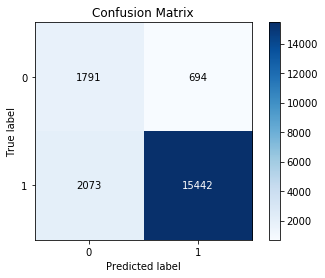

In [167]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)

False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 694/2485 = .27

In [191]:
# FPR for avgw2v_l1
avgw2v_FPR_l1 = .27

In [168]:
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.46      0.72      0.56      2485
          1       0.96      0.88      0.92     17515

avg / total       0.90      0.86      0.87     20000



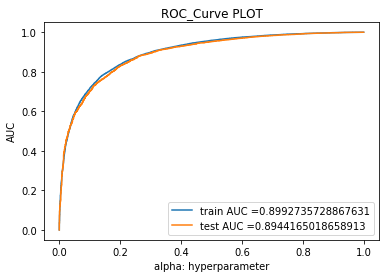

In [169]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, sig_clf.predict_proba(test_avgw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()




Best alpha is:- 0.0001


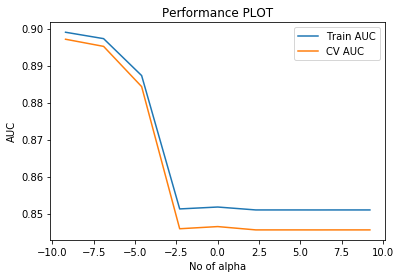

In [170]:
# Please write all the code with proper documentation
# Linear kernel svm for L1 penalty
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

alpha_values = np.arange(10)
 
acc = np.empty(len(alpha_values))
error = np.empty(len(alpha_values))
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])

cv_auc = []
train_auc = []
i = 0
for alpha in C:
    clf = SGDClassifier(loss='hinge',penalty='l2',alpha = alpha,class_weight='balanced')
    clf.fit(train_avgw2v, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_avgw2v, y_train)
    y_cv_pred = sig_clf.predict_proba(cv_avgw2v)[:,1]
    y_train_pred =  sig_clf.predict_proba(train_avgw2v)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best alpha is:-",best_alpha)     
    
    
C = np.log(C)    
    

plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("No of alpha")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [171]:
# SGDClassifier with best best "alpha" for l2 penalty of avgw2v
model = SGDClassifier(loss='hinge',penalty='l2',alpha = best_alpha,class_weight='balanced')
model.fit(train_avgw2v,y_train)
sig_clf = CalibratedClassifierCV(model, method="sigmoid")
sig_clf.fit(train_avgw2v,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(test_avgw2v)    
    # evaluate CV AUC
auc_score_avgw2v_l2 = roc_auc_score(y_true=np.array(y_ts), y_score=sig_clf.predict_proba(test_avgw2v)[:,1])*100
auc_score_avgw2v_lambda_l2 = best_alpha
print('\nThe AUCScore of the SGDClassifier of best alpha = %f is %f%%' % (best_alpha, auc_score_avgw2v_l2))    


The AUCScore of the SGDClassifier of best alpha = 0.000100 is 89.336788%


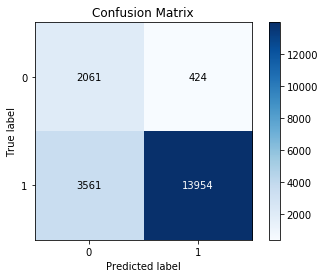

In [172]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)

False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 424/2485 = .17

In [192]:
# FPR for avgw2v_l2
avgw2v_FPR_l2 = .17

In [173]:
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.37      0.83      0.51      2485
          1       0.97      0.80      0.88     17515

avg / total       0.90      0.80      0.83     20000



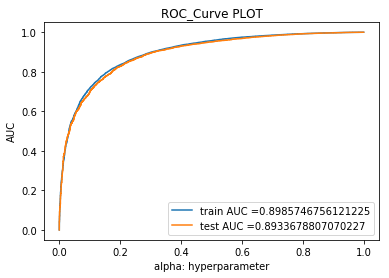

In [174]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, sig_clf.predict_proba(test_avgw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()




### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

Best alpha is:- 0.0001


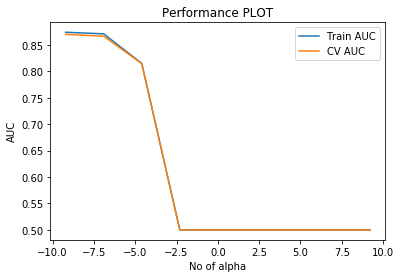

In [175]:
# Please write all the code with proper documentation
# Linear kernel svm for L1 penalty
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

alpha_values = np.arange(10)
 
acc = np.empty(len(alpha_values))
error = np.empty(len(alpha_values))
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])

cv_auc = []
train_auc = []
i = 0
for alpha in C:
    clf = SGDClassifier(loss='hinge',penalty='l1',alpha = alpha,class_weight='balanced')
    clf.fit(tfidf_sent_vectors, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_sent_vectors, y_train)
    y_cv_pred = sig_clf.predict_proba(tfidf_sent_vectors_cv)[:,1]
    y_train_pred =  sig_clf.predict_proba(tfidf_sent_vectors)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best alpha is:-",best_alpha)     
    
    
C = np.log(C)    
    

plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("No of alpha")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [176]:
# SGDClassifier with best best "alpha" for l1 penalty of tfdidf w2v
model = SGDClassifier(loss='hinge',penalty='l1',alpha = best_alpha,class_weight='balanced')
model.fit(tfidf_sent_vectors,y_train)
sig_clf = CalibratedClassifierCV(model, method="sigmoid")
sig_clf.fit(tfidf_sent_vectors,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(tfidf_sent_vectors_ts)    
    # evaluate CV AUC
auc_score_sent_vectors_l1 = roc_auc_score(y_true=np.array(y_ts), y_score=sig_clf.predict_proba(tfidf_sent_vectors_ts)[:,1])*100
auc_score_sent_vectors_lambda_l1 = best_alpha
print('\nThe AUCScore of the SGDClassifier of best alpha = %f is %f%%' % (best_alpha, auc_score_sent_vectors_l1))    


The AUCScore of the SGDClassifier of best alpha = 0.000100 is 86.663858%


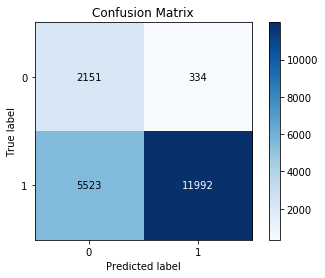

In [177]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)

False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 334/2485 = .13

In [204]:
# FPR for sent_vectors_l1
sent_vectors_FPR_l1 =.13

In [178]:
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.28      0.87      0.42      2485
          1       0.97      0.68      0.80     17515

avg / total       0.89      0.71      0.76     20000



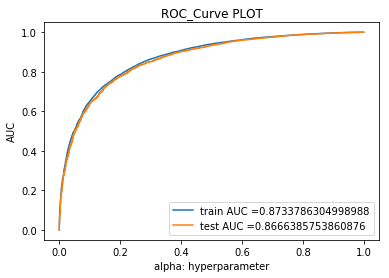

In [179]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(tfidf_sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, sig_clf.predict_proba(tfidf_sent_vectors_ts)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()




Best alpha is:- 0.0001


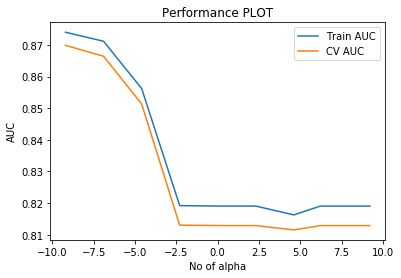

In [180]:
# Please write all the code with proper documentation
# Linear kernel svm for L1 penalty
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

alpha_values = np.arange(10)
 
acc = np.empty(len(alpha_values))
error = np.empty(len(alpha_values))
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])

cv_auc = []
train_auc = []
i = 0
for alpha in C:
    clf = SGDClassifier(loss='hinge',penalty='l2',alpha = alpha,class_weight='balanced')
    clf.fit(tfidf_sent_vectors, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_sent_vectors, y_train)
    y_cv_pred = sig_clf.predict_proba(tfidf_sent_vectors_cv)[:,1]
    y_train_pred =  sig_clf.predict_proba(tfidf_sent_vectors)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best alpha is:-",best_alpha)     
    
    
C = np.log(C)    
    

plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("No of alpha")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [181]:
# SGDClassifier with best best "alpha" for l2 penalty of TFIDF avgw2v
model = SGDClassifier(loss='hinge',penalty='l2',alpha = best_alpha,class_weight='balanced')
model.fit(tfidf_sent_vectors,y_train)
sig_clf = CalibratedClassifierCV(model, method="sigmoid")
sig_clf.fit(tfidf_sent_vectors,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(tfidf_sent_vectors_ts)    
    # evaluate CV AUC
auc_score_sent_vectors_l2 = roc_auc_score(y_true=np.array(y_ts), y_score=sig_clf.predict_proba(tfidf_sent_vectors_ts)[:,1])*100
auc_score_sent_vectors_lambda_l2 = best_alpha
print('\nThe AUCScore of the SGDClassifier of best alpha = %f is %f%%' % (best_alpha, auc_score_sent_vectors_l2))    


The AUCScore of the SGDClassifier of best alpha = 0.000100 is 86.684177%


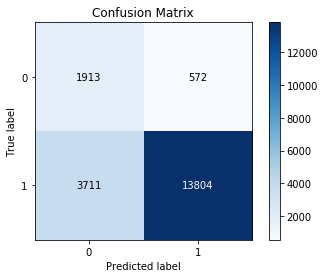

In [182]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)

False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 572/2485 = .23

In [195]:
# FPR for sent_vectors_l2
sent_vectors_FPR_l2 = .23

In [183]:
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.34      0.77      0.47      2485
          1       0.96      0.79      0.87     17515

avg / total       0.88      0.79      0.82     20000



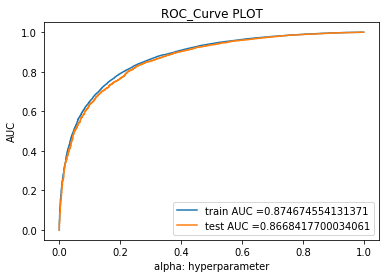

In [184]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(tfidf_sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, sig_clf.predict_proba(tfidf_sent_vectors_ts)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()




## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

Best C is:- 100.0


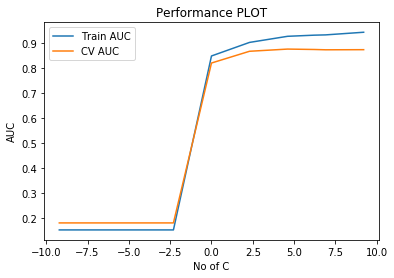

In [77]:
# Please write all the code with proper documentation
# Linear kernel svm for L1 penalty
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score


from sklearn.svm import SVC
alpha_values = np.arange(10)
 
acc = np.empty(len(alpha_values))
error = np.empty(len(alpha_values))
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])

cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    clf = SVC(C = alpha, kernel='rbf',probability=True,class_weight = 'balanced')
    clf.fit(x_tr_final_counts_bigram_rbf, y_train_rbf)
    scores = roc_auc_score(y_true=np.array(y_cv_rbf), y_score=clf.predict_proba(x_cv_final_counts_bigram_rbf)[:,1])
    cv_scores.append(scores)
    scores = roc_auc_score(y_true=np.array(y_train_rbf), y_score=clf.predict_proba(x_tr_final_counts_bigram_rbf)[:,1])
    tr_scores.append(scores)
    i += 1

d = max(cv_scores)

i = np.where(cv_scores == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best C is:-",best_alpha)     
    
    
C = np.log(C)    
    

plt.plot(C, tr_scores, label='Train AUC')
plt.plot(C, cv_scores, label='CV AUC')
plt.legend()
plt.xlabel("No of C")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [78]:
# svm RBF with  best C for  bowT
model = SVC(C = best_alpha,kernel='rbf',probability=True,class_weight = 'balanced')
model.fit(x_tr_final_counts_bigram_rbf,y_train_rbf)
pred = model.predict(x_ts_final_counts_bigram_rbf)
    
    # evaluate CV accuracy
auc_score_bowt_rbf = roc_auc_score(y_true=np.array(y_ts_rbf), y_score=model.predict_proba(x_ts_final_counts_bigram_rbf)[:,1])*100
auc_score_bowt_alpha_rbf = best_alpha
print('\nThe AUCScore of SVM of Best C = %f is %f%%' % (best_alpha, auc_score_bowt_rbf))    


The AUCScore of SVM of Best C = 100.000000 is 87.884186%


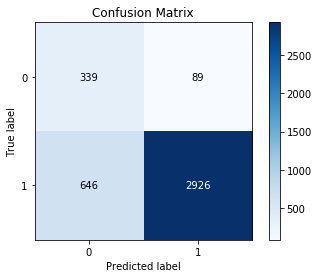

In [79]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts_rbf ,pred)


False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 89/428 = .20

In [196]:
# FPR for bowt_rbf
bowt_rbf_FPR = .20

In [80]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_ts_rbf, pred))

             precision    recall  f1-score   support

          0       0.34      0.79      0.48       428
          1       0.97      0.82      0.89      3572

avg / total       0.90      0.82      0.84      4000



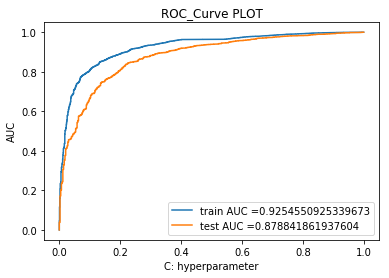

In [81]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train_rbf, model.predict_proba(x_tr_final_counts_bigram_rbf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts_rbf, model.predict_proba(x_ts_final_counts_bigram_rbf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()




### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

Best C is:- 100.0


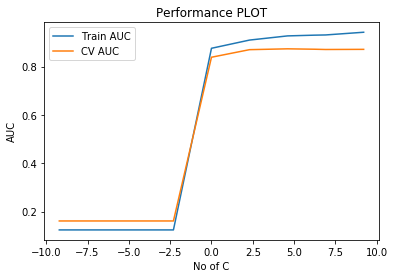

In [82]:
# Please write all the code with proper documentation
# Linear kernel svm for L1 penalty
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score


from sklearn.svm import SVC
alpha_values = np.arange(10)
 
acc = np.empty(len(alpha_values))
error = np.empty(len(alpha_values))
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])

cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    clf = SVC(C = alpha, kernel='rbf',probability=True,class_weight = 'balanced')
    clf.fit(x_tr_final_counts_tfidf_rbf, y_train_rbf)
    scores = roc_auc_score(y_true=np.array(y_cv_rbf), y_score=clf.predict_proba(x_cv_final_counts_tfidf_rbf)[:,1])
    cv_scores.append(scores)
    scores = roc_auc_score(y_true=np.array(y_train_rbf), y_score=clf.predict_proba(x_tr_final_counts_tfidf_rbf)[:,1])
    tr_scores.append(scores)
    i += 1

d = max(cv_scores)

i = np.where(cv_scores == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best C is:-",best_alpha)     
    
    
C = np.log(C)    
    

plt.plot(C, tr_scores, label='Train AUC')
plt.plot(C, cv_scores, label='CV AUC')
plt.legend()
plt.xlabel("No of C")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [83]:
# svm RBF with  best C for  tfidf
model = SVC(C = best_alpha,kernel='rbf',probability=True,class_weight = 'balanced')
model.fit(x_tr_final_counts_tfidf_rbf,y_train_rbf)
pred = model.predict(x_ts_final_counts_tfidf_rbf)
    
    # evaluate CV accuracy
auc_score_tfidf_rbf = roc_auc_score(y_true=np.array(y_ts_rbf), y_score=model.predict_proba(x_ts_final_counts_tfidf_rbf)[:,1])*100
auc_score_tfidf_alpha_rbf = best_alpha
print('\nThe AUCScore of SVM of Best C = %f is %f%%' % (best_alpha, auc_score_tfidf_rbf))    


The AUCScore of SVM of Best C = 100.000000 is 87.678243%


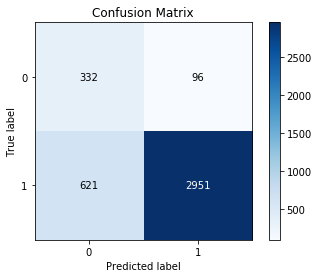

In [84]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts_rbf ,pred)


False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 96/428 = .22

In [197]:
# FPR for tfidf
tfidf_rbf_FPR = .22

In [85]:
print(classification_report(y_ts_rbf, pred))

             precision    recall  f1-score   support

          0       0.35      0.78      0.48       428
          1       0.97      0.83      0.89      3572

avg / total       0.90      0.82      0.85      4000



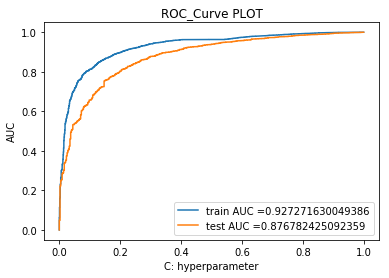

In [86]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train_rbf, model.predict_proba(x_tr_final_counts_tfidf_rbf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts_rbf, model.predict_proba(x_ts_final_counts_tfidf_rbf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()




### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

Best C is:- 10000.0


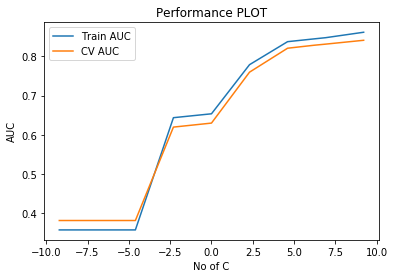

In [87]:
# Please write all the code with proper documentation
# Linear kernel svm for L1 penalty
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score


from sklearn.svm import SVC
alpha_values = np.arange(10)
 
acc = np.empty(len(alpha_values))
error = np.empty(len(alpha_values))
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])

cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    clf = SVC(C = alpha, kernel='rbf',probability=True,class_weight = 'balanced')
    clf.fit(train_avgw2v_rbf, y_train_rbf)
    scores = roc_auc_score(y_true=np.array(y_cv_rbf), y_score=clf.predict_proba(cv_avgw2v_rbf)[:,1])
    cv_scores.append(scores)
    scores = roc_auc_score(y_true=np.array(y_train_rbf), y_score=clf.predict_proba(train_avgw2v_rbf)[:,1])
    tr_scores.append(scores)
    i += 1

d = max(cv_scores)

i = np.where(cv_scores == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best C is:-",best_alpha)     
    
    
C = np.log(C)    
    

plt.plot(C, tr_scores, label='Train AUC')
plt.plot(C, cv_scores, label='CV AUC')
plt.legend()
plt.xlabel("No of C")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [88]:
# svm RBF with  best C for  avgw2v 
model = SVC(C = best_alpha,kernel='rbf',probability=True,class_weight = 'balanced')
model.fit(train_avgw2v_rbf,y_train_rbf)
pred = model.predict(test_avgw2v_rbf)
    
    # evaluate CV accuracy
auc_score_avgword2vec = roc_auc_score(y_true=np.array(y_ts_rbf), y_score=model.predict_proba(test_avgw2v_rbf)[:,1])*100
auc_score_avgword2vec_alpha_rbf = best_alpha
print('\nThe AUCScore of SVM of Best C = %f is %f%%' % (best_alpha, auc_score_avgword2vec))    


The AUCScore of SVM of Best C = 10000.000000 is 84.540259%


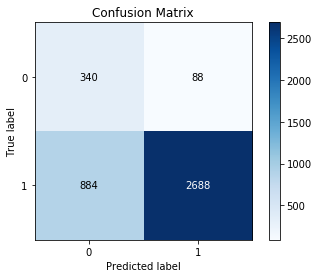

In [89]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts_rbf,pred)

False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 88/428 = .20

In [198]:
# FPR for avg2wec
avgw2v_rbf_FPR = .20

In [90]:
print(classification_report(y_ts_rbf, pred))

             precision    recall  f1-score   support

          0       0.28      0.79      0.41       428
          1       0.97      0.75      0.85      3572

avg / total       0.89      0.76      0.80      4000



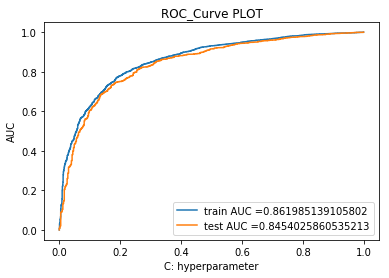

In [91]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train_rbf, model.predict_proba(train_avgw2v_rbf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts_rbf, model.predict_proba(test_avgw2v_rbf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()




### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

Best C is:- 10000.0


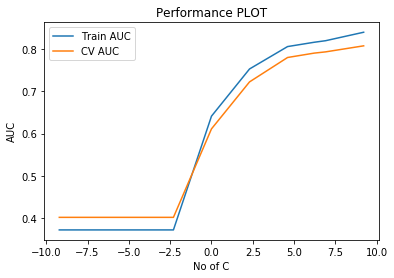

In [92]:
# Please write all the code with proper documentation
# Linear kernel svm for L1 penalty
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score


from sklearn.svm import SVC
alpha_values = np.arange(10)
 
acc = np.empty(len(alpha_values))
error = np.empty(len(alpha_values))
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])

cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    clf = SVC(C = alpha, kernel='rbf',probability=True,class_weight = 'balanced')
    clf.fit(tfidf_sent_vectors_rbf, y_train_rbf)
    scores = roc_auc_score(y_true=np.array(y_cv_rbf), y_score=clf.predict_proba(tfidf_sent_vectors_cv_rbf)[:,1])
    cv_scores.append(scores)
    scores = roc_auc_score(y_true=np.array(y_train_rbf), y_score=clf.predict_proba(tfidf_sent_vectors_rbf)[:,1])
    tr_scores.append(scores)
    i += 1

d = max(cv_scores)

i = np.where(cv_scores == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best C is:-",best_alpha)     
    
    
C = np.log(C)    
    

plt.plot(C, tr_scores, label='Train AUC')
plt.plot(C, cv_scores, label='CV AUC')
plt.legend()
plt.xlabel("No of C")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [93]:
# svm RBF with  best C for tfidf avgw2v
model = SVC(C = best_alpha,kernel='rbf',probability=True,class_weight = 'balanced')
model.fit(tfidf_sent_vectors_rbf,y_train_rbf)
pred = model.predict(tfidf_sent_vectors_ts_rbf)
    
    # evaluate CV accuracy
auc_score_tfidf_we_rbf = roc_auc_score(y_true=np.array(y_ts_rbf), y_score=model.predict_proba(tfidf_sent_vectors_ts_rbf)[:,1])*100
auc_score_tfidf_we_alpha_rbf = best_alpha
print('\nThe AUCScore of SVM of Best C = %f is %f%%' % (best_alpha, auc_score_tfidf_we_rbf))    


The AUCScore of SVM of Best C = 10000.000000 is 82.056016%


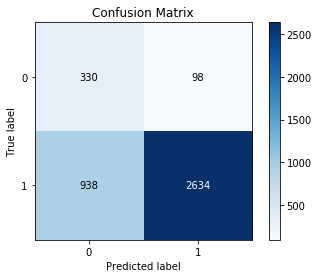

In [94]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts_rbf,pred)

False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 98/428 = .22

In [199]:
# FPR for tfidf_we
tfidf_we_rbf_FPR = .22

In [95]:
print(classification_report(y_ts_rbf, pred))

             precision    recall  f1-score   support

          0       0.26      0.77      0.39       428
          1       0.96      0.74      0.84      3572

avg / total       0.89      0.74      0.79      4000



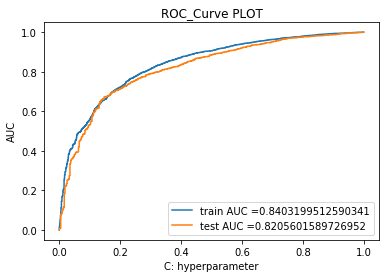

In [96]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train_rbf, model.predict_proba(tfidf_sent_vectors_rbf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts_rbf, model.predict_proba(tfidf_sent_vectors_ts_rbf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()




# [6] Conclusions

In [208]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["SVM","Vectorizer","penalty","hyperparameter","roc_auc_score","FPR"]
x.add_row(["Linear SVM","BOW","L1",auc_score_bowT_lambda_l1,auc_score_bowT_l1,bowt_FPR_l1])
x.add_row(["Linear SVM","BOW","L2",auc_score_bowT_lambda_l2,auc_score_bowT_l2,bowt_FPR_l2])
x.add_row(["Linear SVM","TF-IDF","L1",auc_score_tfidf_lambda_l1,auc_score_tfidf_l1,tfidf_FPR_l1])
x.add_row(["Linear SVM","TF-IDF","L2",auc_score_tfidf_lambda_l2,auc_score_tfidf_l2,tfidf_FPR_l2])
x.add_row(["Linear SVM","AVG -W2V","L1",auc_score_avgw2v_lambda_l1,auc_score_avgw2v_l1,avgw2v_FPR_l1])
x.add_row(["Linear SVM","AVG -W2V","L2",auc_score_avgw2v_lambda_l2,auc_score_avgw2v_l2,avgw2v_FPR_l2])
x.add_row(["Linear SVM","TFIDF-W2V","L1",auc_score_sent_vectors_lambda_l1,auc_score_sent_vectors_l1,sent_vectors_FPR_l1])
x.add_row(["Linear SVM","TFIDF-W2V","L2",auc_score_sent_vectors_lambda_l2,auc_score_sent_vectors_l2,sent_vectors_FPR_l2])
x.add_row(["RBF SVM","BOW","NA",auc_score_bowt_alpha_rbf,auc_score_bowt_rbf,bowt_rbf_FPR])
x.add_row(["RBF SVM","TFIDF","NA",auc_score_tfidf_alpha_rbf,auc_score_tfidf_rbf,tfidf_rbf_FPR])
x.add_row(["RBF SVM","avgw2v","NA",auc_score_avgword2vec_alpha_rbf,auc_score_avgword2vec,avgw2v_rbf_FPR])
x.add_row(["RBF SVM","TFIDF W2V","NA",auc_score_tfidf_we_alpha_rbf,auc_score_tfidf_we_rbf,tfidf_we_rbf_FPR])



print(x)

+------------+------------+---------+----------------+-------------------+------+
|    SVM     | Vectorizer | penalty | hyperparameter |   roc_auc_score   | FPR  |
+------------+------------+---------+----------------+-------------------+------+
| Linear SVM |    BOW     |    L1   |     0.0001     | 93.24373991594442 | 0.14 |
| Linear SVM |    BOW     |    L2   |     0.0001     | 94.25636088871224 | 0.12 |
| Linear SVM |   TF-IDF   |    L1   |     0.0001     | 93.42592580892146 | 0.14 |
| Linear SVM |   TF-IDF   |    L2   |     0.0001     |  94.9925117361319 | 0.12 |
| Linear SVM |  AVG -W2V  |    L1   |     0.0001     | 89.44165018658913 | 0.27 |
| Linear SVM |  AVG -W2V  |    L2   |     0.0001     | 89.33678807070227 | 0.17 |
| Linear SVM | TFIDF-W2V  |    L1   |     0.0001     | 86.66385753860875 | 0.13 |
| Linear SVM | TFIDF-W2V  |    L2   |     0.0001     | 86.68417700034061 | 0.23 |
|  RBF SVM   |    BOW     |    NA   |     100.0      |  87.8841861937604 | 0.2  |
|  RBF SVM   |  

as per the table, we can consider TFIDF with L2 regularizor(Linear SVM) because it has less false positive rate  and more roc_auc_score